# Lower limits of detection of Malaria Parasites in dried blood spots when using Mid-Infrared Spectroscopy and Machine Learning approaches in presence and absence of anemia 


*This notebook contains the code for evaluating the LLOD of malaria parasite in DBS using IR-ML, it has only considered non-enemic samples*

* The data has been generated from Bagamoyo culture facility from 2021-2023. 
* It contains all MIRs wave numbers from the data.

###  Mshani Issa ##



##  Importing all useful Libraries for our analyis ##

In [2]:
#Import impontant modules

import numpy as np 
import pandas as pd  
import scipy.stats as stats

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold

#Import ML classifiers
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

import os
import ast
import itertools
import collections
from time import time
from tqdm import tqdm 
import collections
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting


 LOADING OUR DATA AND INSPECTING IT.

In [3]:
df=pd.read_csv('No_Anemia_50HM_alldata.csv') #loading all parasitimia data at 50% hematocrits

In [4]:
df.head(5) # explore the heading

,Unnamed: 0,Cat4,Cat5,3855,3853,3851,3849,3847,3845,3843,...,545,543,541,539,537,535,533,531,529,527
0,40,50HM,0PRS,0.0127,0.0124,0.0123,0.0123,0.0124,0.0125,0.0125,...,0.1087,0.1071,0.1084,0.1086,0.1053,0.1020,0.1031,0.1072,0.1100,0.1098
1,41,50HM,0PRS,0.0127,0.0124,0.0124,0.0125,0.0127,0.0126,0.0125,...,0.1088,0.1055,0.1067,0.1086,0.1089,0.1094,0.1104,0.1116,0.1140,0.1172
2,42,50HM,0PRS,0.0131,0.0128,0.0128,0.0129,0.0130,0.0130,0.0129,...,0.1094,0.1066,0.1092,0.1131,0.1150,0.1152,0.1162,0.1208,0.1285,0.1344
3,43,50HM,0PRS,0.0139,0.0136,0.0135,0.0135,0.0136,0.0137,0.0138,...,0.1073,0.1072,0.1116,0.1160,0.1183,0.1203,0.1227,0.1234,0.1225,0.1209
4,44,50HM,0PRS,0.0141,0.0138,0.0137,0.0138,0.0139,0.0139,0.0138,...,0.1165,0.1179,0.1225,0.1276,0.1302,0.1278,0.1220,0.1173,0.1169,0.1201


In [5]:
# investigating the presence of the missing values in the whole data
print('missing values:',df.isnull().sum())

missing values: Unnamed: 0    0
Cat4          0
Cat5          0
3855          0
3853          0
             ..
535           0
533           0
531           0
529           0
527           0
Length: 1668, dtype: int64


# Feature and Engeenering 



In [6]:
#First we will drop all columns which are out of our interest like Cat4 etc
df= df.drop(['Cat4', 'Unnamed: 0'], axis=1)
df

,Cat5,3855,3853,3851,3849,3847,3845,3843,3841,3839,...,545,543,541,539,537,535,533,531,529,527
0,0PRS,0.0127,0.0124,0.0123,0.0123,0.0124,0.0125,0.0125,0.0125,0.0125,...,0.1087,0.1071,0.1084,0.1086,0.1053,0.1020,0.1031,0.1072,0.1100,0.1098
1,0PRS,0.0127,0.0124,0.0124,0.0125,0.0127,0.0126,0.0125,0.0124,0.0124,...,0.1088,0.1055,0.1067,0.1086,0.1089,0.1094,0.1104,0.1116,0.1140,0.1172
2,0PRS,0.0131,0.0128,0.0128,0.0129,0.0130,0.0130,0.0129,0.0129,0.0129,...,0.1094,0.1066,0.1092,0.1131,0.1150,0.1152,0.1162,0.1208,0.1285,0.1344
3,0PRS,0.0139,0.0136,0.0135,0.0135,0.0136,0.0137,0.0138,0.0138,0.0139,...,0.1073,0.1072,0.1116,0.1160,0.1183,0.1203,0.1227,0.1234,0.1225,0.1209
4,0PRS,0.0141,0.0138,0.0137,0.0138,0.0139,0.0139,0.0138,0.0137,0.0137,...,0.1165,0.1179,0.1225,0.1276,0.1302,0.1278,0.1220,0.1173,0.1169,0.1201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,6PRS,0.0140,0.0137,0.0133,0.0131,0.0132,0.0133,0.0132,0.0133,0.0132,...,0.1343,0.1299,0.1277,0.1272,0.1269,0.1294,0.1341,0.1346,0.1312,0.1293
1648,6PRS,0.0141,0.0136,0.0131,0.0130,0.0132,0.0134,0.0137,0.0140,0.0140,...,0.1381,0.1409,0.1408,0.1382,0.1345,0.1299,0.1258,0.1245,0.1246,0.1213
1649,6PRS,0.0152,0.0154,0.0131,0.0117,0.0120,0.0128,0.0133,0.0138,0.0140,...,0.1471,0.1435,0.1380,0.1306,0.1243,0.1212,0.1195,0.1203,0.1244,0.1253
1650,6PRS,0.0158,0.0158,0.0155,0.0153,0.0152,0.0154,0.0156,0.0160,0.0160,...,0.1264,0.1205,0.1186,0.1202,0.1229,0.1271,0.1345,0.1432,0.1476,0.1429


In [7]:
#Exploring number of observations based to the parasitemia (Cat5)
grouped_df = df.groupby(['Cat5',]).size().reset_index(name="Count")
grouped_df


,Cat5,Count
0,0.00003PRS,340
1,0.002PRS,323
2,0.1PRS,332
3,0PRS,314
4,6PRS,343


# Create and save Training & validation set as 30% of all non Anemic data

In [8]:
# # Taking 30 % of the data for Validation set
randomsplit= ShuffleSplit(n_splits=10, test_size=0.3, random_state=None) # 10 randomsplit 
randomsplit.get_n_splits(df)
print(randomsplit)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.3, train_size=None)


In [9]:
for train_set, validation_set in randomsplit.split(df):
    print("Train_set:", train_set, "validation_set:", validation_set);
    print(train_set.shape, validation_set.shape);
    
## Training data_set saving
    
df.iloc[train_set,:]
training_data = df.iloc[train_set,:]
training_data.to_csv("No_Anemia_50%_Final_train.csv")

## validation set  saving
df.iloc[validation_set,:]
validation_data = df.iloc[validation_set,:]
validation_data.to_csv("No_Anemia_50%_Final_validation.csv")

Train_set: [ 569 1332   80 ...   56  372  743] validation_set: [1213 1386 1575  180  957    5  693 1642  954 1065  443  598  643 1473
 1047  881 1341 1446  430 1201  146 1635  269 1228   51 1134  281  415
  143  460   95  975 1431 1112 1154 1287  206  938  794  365  117  835
 1517  620 1135 1117  735 1394  627 1647  809  653 1302   62  878  898
 1096  520  629 1026  921  105  727 1384  216   39 1343  313 1568  358
 1307  224 1621  385  648 1254  402  818 1589    8  517  758 1241  635
  972  844 1505 1572  506   55 1564  798  732  380  686  145  316  911
  465  378 1182 1504  678  940  453 1408 1554  469 1359  159 1351 1070
 1001  765 1175  617 1502  315  673  484  255  950 1111  845  231  252
  534  979  994 1163 1139 1038 1353  889  310 1543  875 1648  712 1464
  428 1097  371 1534  525 1077 1401 1435  547 1368  556 1497  325 1215
 1054 1590 1518  349  501  790  899 1409   73  274   72  273 1125 1367
  498  529 1123  279  177  155 1008 1501 1376  751  440  179 1092 1115
  356  581 109

In [10]:
df2 = pd.read_csv("No_Anemia_50%_Final_train.csv") #Load our train set only for training and test
df2.shape

(1156, 1667)

### Selection of only highest parasitemia (6%) vs 0% for model training to pick actual positive
* Select the response/ vector of target (y class) as malaria positive (6% parasitemia) and Negative (0%)
* Select the explanatory/independent/input_variables/matrix of features (I have excluded the flat region)
* To balance the classes, i randomly undersampling the large class



In [11]:
df2 = df2[(df2["Cat5"] == '6PRS') | (df2["Cat5"] == '0PRS')] # select 6% parasitimia and 0% parasitemia
grouped_df2 = df2.groupby(['Cat5']).size().reset_index(name="Count") # Group by Parasitemia
grouped_df2

,Cat5,Count
0,0PRS,230
1,6PRS,233


In [12]:
df2["Cat5"]=df2["Cat5"].replace({'6PRS': 'Positive', '0PRS': 'Negative'}) #rename 6% vs 0% to positive and negative

In [14]:
#Feature selection in the paper, basically the wavenumber from the light scattering region was excluded
X1= df2.loc[:,'3101':'2801'] 
X2= df2.loc[:,'1799':'899']
X =  pd.concat([X1, X2], axis=1)
y = df2["Cat5"] # Vector of targets
print(X)
print(y)

        3101    3099    3097    3095    3093    3091    3089    3087    3085  \
1     0.0393  0.0390  0.0388  0.0386  0.0384  0.0384  0.0384  0.0382  0.0380   
3     0.0406  0.0405  0.0404  0.0402  0.0400  0.0398  0.0397  0.0395  0.0393   
7     0.0358  0.0357  0.0357  0.0356  0.0354  0.0353  0.0352  0.0352  0.0351   
13    0.0366  0.0366  0.0366  0.0364  0.0363  0.0361  0.0359  0.0357  0.0355   
15    0.0353  0.0351  0.0350  0.0349  0.0348  0.0347  0.0346  0.0345  0.0343   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1147  0.0260  0.0261  0.0259  0.0257  0.0256  0.0256  0.0257  0.0257  0.0255   
1148  0.0344  0.0341  0.0340  0.0340  0.0340  0.0340  0.0340  0.0341  0.0341   
1149  0.0441  0.0436  0.0432  0.0431  0.0430  0.0430  0.0429  0.0427  0.0425   
1153  0.0310  0.0308  0.0305  0.0303  0.0302  0.0301  0.0299  0.0297  0.0297   
1154  0.0394  0.0393  0.0392  0.0392  0.0390  0.0388  0.0386  0.0385  0.0383   

        3083  ...     917     915     9

In [15]:
#Exploring number of observations based to the parasitemia (Cat5)
grouped_df = df2.groupby(['Cat5',]).size().reset_index(name="Count")
grouped_df

,Cat5,Count
0,Negative,230
1,Positive,233


In [16]:
X.shape 

(463, 602)

In [17]:
RSC= RandomUnderSampler(random_state = None) # balancing classes by rondom undersampling technique
X_us, y_us = RSC.fit_sample(X, y)
y_us_count = collections.Counter(y_us)
print(y_us_count)

Counter({'Negative': 230, 'Positive': 230})


# Model selection 
* By Cross Validation, I evaluated the best performing model
* I have used 80% of the data for training and 20% of the data for the test
* I have used accuracy for best model selection

In [18]:
Test_size = 0.2 # % of train set to be tested under cross validation
num_folds = 10 # 10 folds for cross validation of a train data 
seed = None
scoring = 'accuracy' # accuracy scored by each model
kfold= StratifiedShuffleSplit(n_splits=num_folds, random_state=seed) # CV approach



In [19]:
# Stardadize the data set
X_us = MinMaxScaler().fit_transform(X_us)
X_us

array([[0.712     , 0.72289157, 0.72580645, ..., 0.63333333, 0.62768496,
        0.62589928],
       [0.128     , 0.13253012, 0.12903226, ..., 0.22857143, 0.22673031,
        0.22781775],
       [0.78      , 0.79116466, 0.79032258, ..., 0.70238095, 0.70405728,
        0.70743405],
       ...,
       [0.756     , 0.76305221, 0.76209677, ..., 0.65238095, 0.64916468,
        0.6498801 ],
       [0.76      , 0.76706827, 0.76612903, ..., 0.73809524, 0.73747017,
        0.73860911],
       [0.336     , 0.34136546, 0.33467742, ..., 0.35      , 0.34844869,
        0.35251799]])

# IMPORTING CLASSIFIERS 

In [20]:
models = [] # creating models sub names
models.append(("KNN", KNeighborsClassifier()))
models.append(("LR", LogisticRegressionCV(cv = kfold, max_iter=15000)))
models.append(("SVM", SVC(kernel='linear',gamma = 'auto')))
models.append(("RF", RandomForestClassifier(n_estimators = 500)))
models.append(("XGB", GradientBoostingClassifier()))
models.append(("ET", ExtraTreesClassifier(n_estimators=500 )))
models.append(("BGC",BaggingClassifier()))
#models.append(("LDA",LinearDiscriminantAnalysis()))

In [21]:
results = [] # results container
names = [] # Model name container

#Take each model for CV and return results 
for name, model in models: 
    StratifiedShuffleSplit
    kfold= StratifiedShuffleSplit(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(
        model, X_us, y_us, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Cross val score for {0}: {1:.2%} ± {2:.2%}".format(
        name, cv_results.mean(), cv_results.std())
    print(msg)

Cross val score for KNN: 73.48% ± 3.61%
Cross val score for LR: 97.61% ± 1.52%
Cross val score for SVM: 81.74% ± 3.40%
Cross val score for RF: 72.39% ± 7.41%
Cross val score for XGB: 72.83% ± 7.91%
Cross val score for ET: 74.13% ± 7.62%
Cross val score for BGC: 68.91% ± 5.50%


<Figure size 864x576 with 0 Axes>

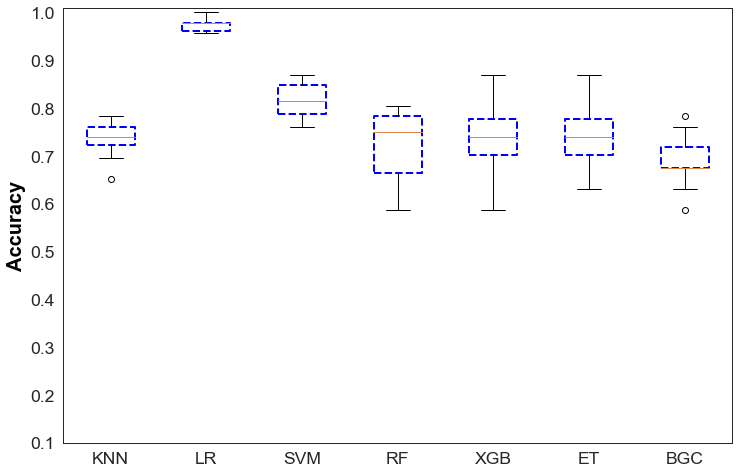

<Figure size 864x576 with 0 Axes>

In [39]:
# Drawing the accuracy

from matplotlib import rcParams

sns.set(context="paper",

    style="white",

    font_scale=2.0,
        
    rc={"font.family": "sans-serif"})
rcParams['font.sans-serif'] = 'Arial'

sns.despine(offset=10, trim=False)

plt.rcParams["figure.figsize"] = [12,8]

ax = fig.add_subplot(111)

# Set y-axis limits
ax.set_ylim(0.1, 1.01)
plt.ylabel('Accuracy', color= 'black',fontsize=20, Weight="bold")
plt.boxplot(results, boxprops=dict(linestyle='--', linewidth=2, color='blue'))
ax.set_xticklabels(names)
plt.show()

#plt.savefig ("ModelSelectionHighestParasitemiaVsZero.png",dpi = 300, bbox_inches="tight")


In [41]:
## split out test set

X_train, X_test, y_train, y_test = train_test_split(X_us,y_us,
test_size=0.2, random_state=None)

# define model
model = LogisticRegressionCV(cv = kfold, max_iter=3500)

model.fit(X_train, y_train )

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.83%


In [43]:
#Convert string labels to numeric labels using LabelEncoder
label_encoder = LabelEncoder()
true_numeric_labels = label_encoder.fit_transform(y_test)
predicted_numeric_labels = label_encoder.transform(y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_numeric_labels, predicted_numeric_labels)

# Extract true negatives, false positives, false negatives, true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate precision, recall, and specificity
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the metrics
print("Precision: {:.2f}".format(precision))
print("Recall (Sensitivity): {:.2f}".format(recall))
print("Specificity: {:.2f}".format(specificity))

Precision: 0.96
Recall (Sensitivity): 1.00
Specificity: 0.96


# PLOTTING CONFUSION MATRICES

In [44]:

def plot_confusion_matrix(cm, classes,
                          normalise=True,
                          text=False,
                          title='Confusion matrix',color='r',
                          xrotation=0,
                          yrotation=0,
                          saturation=2,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting 'normalise=True'.
    """
    
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "{0} (normalised)".format(title)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0.009,0.91], ["Positive", 'Negative'],fontsize=18)
    plt.yticks([0.008,0.81], ["Positive", 'Negative'],fontsize=18,rotation=90)

    if text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]),
                                      range(cm.shape[1])):
            plt.text(j, i, "{0:.2f}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color= 'black',fontsize=20, Weight="bold")
    plt.xlabel('Predicted label', color='black',fontsize=20, Weight="bold")

Normalized confusion matrix


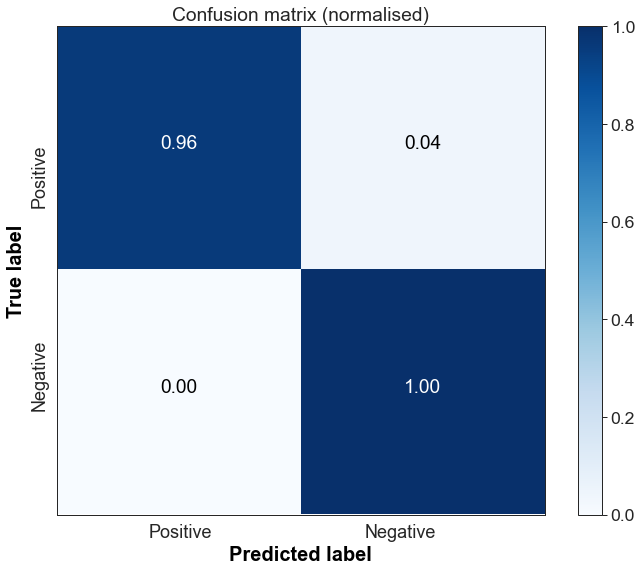

In [45]:
#  confusion matrix
sns.set(context="paper",
        style="white",
        font_scale=2.0,
        rc={"font.family": "sans-serif"})

rcParams['font.sans-serif'] = 'Arial'

plt.rcParams["figure.figsize"] = [10,8]
cm = confusion_matrix(y_test, y_pred)

class_names = np.unique(np.sort(y))

plot_confusion_matrix(cm, text=True, normalise=True, classes=class_names)
plt.savefig ("UntunedLR_6%vs0%_Confusio_matrix.png",dpi = 300, bbox_inches="tight")

Model accuracy is reported on the test set. 10 bootstrapped samples Median accuracy is 0.96 with a 95% a confidence interval of [0.93,0.99].


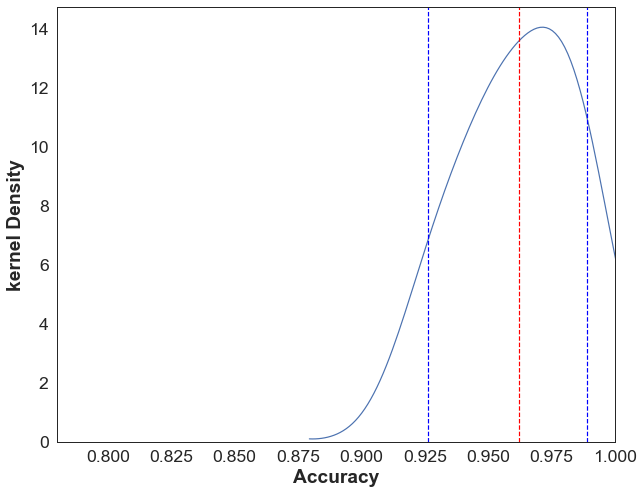

In [46]:
#### Bootstrapping ####
########################################################

AccuracyValues=[] # Creating empty list to hold accuracy values
n_times=100
 
## Performing bootstrapping
for i in range(n_times):
    X_train, X_test, y_train, y_test = train_test_split(X_us,y_us,test_size=0.2, random_state=None)

# define model
    model2 = LogisticRegressionCV(cv = kfold, max_iter=3500)

    model2.fit(X_train, y_train )

    y_pred_ = model2.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_)
    

    AccuracyValues.append(accuracy)
    
################################################

median = np.percentile(AccuracyValues, 50) # get median

# get 95% interval
alpha = 100-95
lower_ci = np.percentile(AccuracyValues, alpha/2)
upper_ci = np.percentile(AccuracyValues, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################


sns.kdeplot(AccuracyValues)
plt.xlabel("Accuracy", weight='bold')
plt.ylabel("kernel Density", weight='bold')
plt.xlim(0.78,1)
plt.axvline(median,0, 14, linestyle="--", color="Red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="blue")
plt.axvline(upper_ci,0, 14, linestyle="--", color="Blue")
plt.show()

####################################################

# Tunning the model

In [47]:

num_splits = 10 # split training set into 10 parts 

validation_size = 0.2 # size of the test set

seed = 7 # pick any integer. This ensures reproducibility of the tests

scoring = 'accuracy' # score model accuracy

# preparing the model

classifier =LogisticRegressionCV(Cs = 10,

                                cv = kfold,

                                max_iter = 3500,  

                                multi_class = 'auto', 

                                random_state = seed)

# Defining hyperparameters

solver = ['lbfgs', 'newton-cg']

param_grid = dict(solver = solver)
          
sss = kfold
# prepare matrices of results

sss_results = pd.DataFrame() # model parameters and global accuracy score
 
sss_per_class_results = [] # per class accuracy scores

start = time()

for train_index, test_index in sss.split(X_us, y_us):

    X_train, X_test = X_us[train_index], X_us[test_index]

    y_train, y_test = y_us[train_index], y_us[test_index]

# GRID SEARCH

    grid = GridSearchCV(estimator=classifier, param_grid = param_grid, scoring=scoring, cv=sss) 

    grid_result = grid.fit(X_train, y_train)

#  hyperparameter settings and results printing

    means = grid_result.cv_results_['mean_test_score']

    stds = grid_result.cv_results_['std_test_score']

    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):

           print("%.2f (%.2f) with: %r" % (mean, stdev, param))

# print best parameter settings

    print("Best: %.2f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    best_classifier = LogisticRegressionCV(Cs=10,max_iter=3500,random_state=seed,multi_class='auto',**grid_result.best_params_)

# Fitting the best model

    best_classifier.fit(X_train, y_train)

# testing model 

    y_pred = best_classifier.predict(X_test)

    local_cm = confusion_matrix(y_test, y_pred)

    local_report = classification_report(y_test, y_pred)

    local_sss_results=pd.DataFrame([("Accuracy",accuracy_score(y_test, y_pred)), ("params",str(grid_result.best_params_)), ("TRAIN",str(train_index)), ("TEST",str(test_index)), ("CM", local_cm), ("Classification report", local_report)]).T

    local_sss_results.columns=local_sss_results.iloc[0]

    local_sss_results = local_sss_results[1:]

    sss_results = sss_results.append(local_sss_results)

# per class accuracy

    local_support = precision_recall_fscore_support(y_test, y_pred)[3]

    local_acc = np.diag(local_cm)/local_support

    sss_per_class_results.append(local_acc)

elapsed = time() - start

print("Time elapsed: {0:.2f} minutes ({1:.1f} sec)".format( 
    elapsed / 60, elapsed))

0.96 (0.02) with: {'solver': 'lbfgs'}
0.97 (0.02) with: {'solver': 'newton-cg'}
Best: 0.97 using {'solver': 'newton-cg'}
0.98 (0.02) with: {'solver': 'lbfgs'}
0.98 (0.02) with: {'solver': 'newton-cg'}
Best: 0.98 using {'solver': 'lbfgs'}
0.97 (0.03) with: {'solver': 'lbfgs'}
0.97 (0.03) with: {'solver': 'newton-cg'}
Best: 0.97 using {'solver': 'lbfgs'}
0.98 (0.02) with: {'solver': 'lbfgs'}
0.97 (0.02) with: {'solver': 'newton-cg'}
Best: 0.98 using {'solver': 'lbfgs'}
0.97 (0.02) with: {'solver': 'lbfgs'}
0.97 (0.02) with: {'solver': 'newton-cg'}
Best: 0.97 using {'solver': 'lbfgs'}
0.96 (0.02) with: {'solver': 'lbfgs'}
0.96 (0.02) with: {'solver': 'newton-cg'}
Best: 0.96 using {'solver': 'lbfgs'}
0.97 (0.02) with: {'solver': 'lbfgs'}
0.97 (0.02) with: {'solver': 'newton-cg'}
Best: 0.97 using {'solver': 'lbfgs'}
0.96 (0.04) with: {'solver': 'lbfgs'}
0.95 (0.04) with: {'solver': 'newton-cg'}
Best: 0.96 using {'solver': 'lbfgs'}
0.97 (0.02) with: {'solver': 'lbfgs'}
0.97 (0.02) with: {'so

In [48]:
# Results

sss_results.to_csv("lgr_sssCV_record.csv", index=False)

sss_results = pd.read_csv("lgr_sssCV_record.csv")

# Accuracy distribution

lgr_acc_distrib = sss_results["Accuracy"]

lgr_acc_distrib.columns=["Accuracy"]

lgr_acc_distrib.to_csv("lgr_acc_distrib.csv", header=True, index=False)

lgr_acc_distrib = pd.read_csv("lgr_acc_distrib.csv")

lgr_acc_distrib = np.round(100*lgr_acc_distrib)

print(lgr_acc_distrib)

   Accuracy
0      98.0
1      98.0
2     100.0
3      93.0
4      96.0
5      98.0
6      98.0
7      96.0
8     100.0
9      96.0


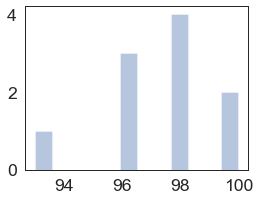

In [49]:
# plotting accuracy distribution

plt.figure(figsize=(4,3))

sns.distplot(lgr_acc_distrib, kde=False, bins=12)

plt.savefig("HighestParasitemiaTraining_Violin_plot.png", bbox_inches="tight")



In [50]:
Accuracy = np.mean(lgr_acc_distrib)  # Calculate mean score
std_dev = np.std(lgr_acc_distrib)  # Calculate standard deviation of scores

# Calculate the 95% confidence interval
lower_bound = np.percentile(lgr_acc_distrib, 2.5)  # 2.5th percentile
upper_bound = np.percentile(lgr_acc_distrib, 97.5)  # 97.5th percentile

print("95% Confidence Interval: [{:.2f}, {:.2f}]".format(lower_bound, upper_bound))

95% Confidence Interval: [93.68, 100.00]


In [51]:
lgr_per_class_acc_distrib = pd.DataFrame(sss_per_class_results, columns=class_names)

lgr_per_class_acc_distrib.dropna().to_csv("lgr_per_class_acc_distrib.csv")

lgr_per_class_acc_distrib = pd.read_csv("lgr_per_class_acc_distrib.csv", index_col=0)

lgr_per_class_acc_distrib = np.round(100*lgr_per_class_acc_distrib)

lgr_per_class_acc_distrib_describe = lgr_per_class_acc_distrib.describe()

lgr_per_class_acc_distrib_describe.to_csv("lgr_per_class_acc_distrib.csv")

In [53]:
lgr_per_class_acc_distrib = pd.DataFrame(sss_per_class_results, columns=class_names)

lgr_per_class_acc_distrib.dropna().to_csv("lgr_per_class_acc_distrib.csv")

lgr_per_class_acc_distrib = pd.read_csv("lgr_per_class_acc_distrib.csv", index_col=0)

lgr_per_class_acc_distrib = np.round(100*lgr_per_class_acc_distrib)

lgr_per_class_acc_distrib_describe = lgr_per_class_acc_distrib.describe()

lgr_per_class_acc_distrib_describe.to_csv("lgr_per_class_acc_distrib.csv")

# Lets look on the confusion matrix and save the best classifier

Normalized confusion matrix


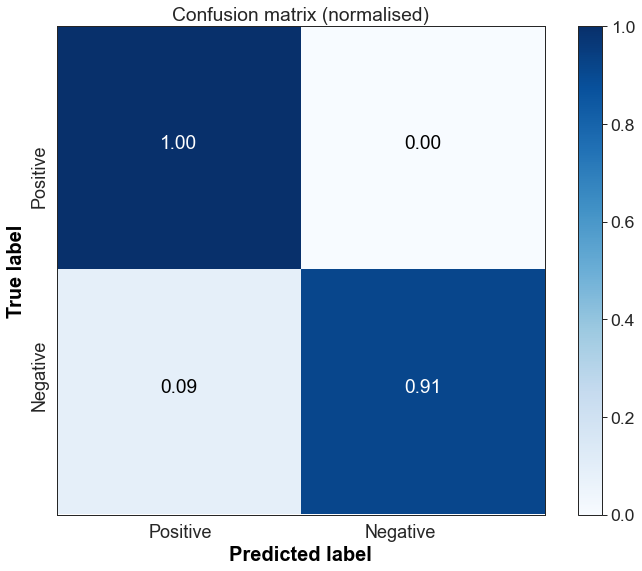

In [54]:
# plot the prediction accuracy as a confusion matrix

plt.rcParams["figure.figsize"] = [10,8]

class_names = np.unique(np.sort(y))

plot_confusion_matrix(local_cm, text=True, normalise=True, classes=class_names)

#plt.savefig("prediction tuned_LR_DE.png", dpi = 300, bbox_inches="tight")

In [57]:
#Convert string labels to numeric labels using LabelEncoder
label_encoder = LabelEncoder()
true_numeric_labels = label_encoder.fit_transform(y_test)
predicted_numeric_labels = label_encoder.transform(y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_numeric_labels, predicted_numeric_labels)

# Extract true negatives, false positives, false negatives, true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate precision, recall, and specificity
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the metrics
print("Precision: {:.2f}".format(precision))
print("Recall (Sensitivity): {:.2f}".format(recall))
print("Specificity: {:.2f}".format(specificity))

Precision: 1.00
Recall (Sensitivity): 0.91
Specificity: 1.00


In [58]:

# Summarising precision, f_score, and recall for the training set

cr = local_report

print(cr)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96        23
    Positive       1.00      0.91      0.95        23

    accuracy                           0.96        46
   macro avg       0.96      0.96      0.96        46
weighted avg       0.96      0.96      0.96        46



Logistic ROC AUC 0.977


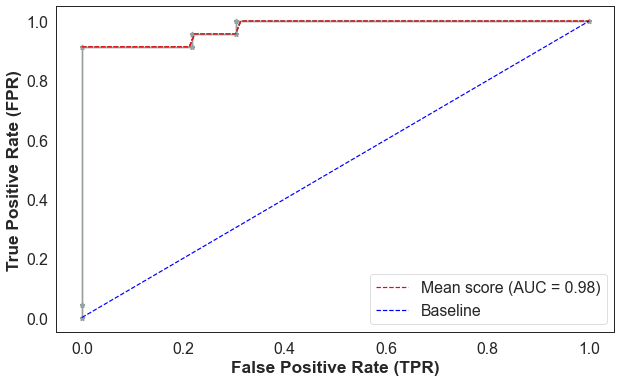

In [59]:
# Lets work for ROC-AUC 

# Train 10 different logistic regression models
models = []
for i in range(10):
    model = LogisticRegressionCV(Cs=10,max_iter=3500,
                                           random_state=i,multi_class='auto',
                                           **grid_result.best_params_)
    model.fit(X_train, y_train)
    models.append(model)

# Compute ROC and AUC for each model
plt.figure(figsize=(10, 6))

mean_fpr = np.linspace(0, 1, 100)

for i,model in enumerate(models):
    y_scores = model.predict_proba(X_test)[:, 1]
    # Convert string labels to binary labels
    y_true_binary = (y_test == 'Positive').astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
    # plot baseline roc curve
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, marker='*',alpha=0.3)

    # Calculate standard deviation for each point along the ROC curve
    tpr_std = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in [roc_curve(y_true_binary, model.predict_proba(X_test)[:, 1]) for model in models]], axis=0)
    
    # Plot standard deviation lines above and below the ROC curve
    plt.plot(mean_fpr, np.interp(mean_fpr, fpr, tpr) + tpr_std, '--', color='gray', alpha=0.5)
    plt.plot(mean_fpr, np.interp(mean_fpr, fpr, tpr) - tpr_std, '--', color='gray', alpha=0.5)

# Compute and plot the average ROC curve
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in [roc_curve(y_true_binary, model.predict_proba(X_test)[:, 1]) for model in models]], 
                   axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label=f'Mean score (AUC = {mean_auc:.2f})', color='red', linestyle='--')

# axis labels
plt.xlabel('False Positive Rate (TPR)', weight= 'bold')
plt.ylabel('True Positive Rate (FPR)', weight = 'bold')
plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline', color='blue')
print('Logistic ROC AUC %.3f' % roc_auc)

plt.legend()
plt.show()

## We save our best classifier for validation of different parasitemia and anemic conditions

In [61]:
import pickle

#Save the model to a file using pickle
with open('Malaria_classifier.pk2', 'wb') as file:
    pickle.dump(best_classifier, file)

# Unpickle the model from the file
#with open('Malaria_classifier.pk1', 'rb') as file:
    #loaded_model = pickle.load(file)


In [62]:
import joblib
#Save the model as joblib
model_filename = 'Model_01_With_Few_wave_numbers_.joblib'
joblib.dump(best_classifier, model_filename)

['Model_01_With_Few_wave_numbers_.joblib']